In [1]:
from vivarium import Artifact
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from db_queries import get_ids, get_outputs
import scipy.stats

In [2]:
output_dirs = ['/ihme/costeffectiveness/results/vivarium_conic_lsff/v1.0_disease_only/ethiopia/2020_02_26_16_15_59/count_data/',
               '/ihme/costeffectiveness/results/vivarium_conic_lsff/v1.0_disease_only/india/2020_02_26_16_17_48/count_data/',
               '/ihme/costeffectiveness/results/vivarium_conic_lsff/v1.0_disease_only/nigeria/2020_02_26_16_19_00/count_data/']

locations = ['Ethiopia','India','Nigeria']

In [3]:
transition = pd.read_hdf(output_dirs[1] + 'transition_count.hdf')
transition = transition.where(transition['measure'].str.contains('measles'))
transition = (transition.groupby(['age_group','measure','input_draw'], as_index=False).sum())      
transition = (pd.pivot_table(transition, index=['input_draw','age_group'], columns='measure',
                          values='value').reset_index()
              .rename(columns={'measles_to_susceptible_to_measles_event_count':'incident_count',
                            'susceptible_to_measles_to_measles_event_count':'remission_count'}))
transition.head()

measure,input_draw,age_group,incident_count,remission_count
0,21.0,1_to_4,0.0,41734.0
1,21.0,early_neonatal,0.0,0.0
2,21.0,late_neonatal,0.0,0.0
3,21.0,post_neonatal,0.0,15480.0
4,29.0,1_to_4,0.0,54177.0


In [4]:
np.unique(transition['incident_count'])

array([0.])

In [5]:
# get model results from fixed_scenarios folder

def get_cause_specific_model_results(cause):
    master_data = pd.DataFrame()
    for i in list(range(len(output_dirs))):
        deaths = pd.read_hdf(output_dirs[i] + 'deaths.hdf')
        deaths = (deaths.where(deaths['cause'].str.contains(cause)).dropna()
                  .groupby(['input_draw','age_group'], as_index=False).sum()
                  .rename(columns={'value':'deaths'}))
        pt = pd.read_hdf(output_dirs[i] + 'person_time.hdf')
        pt = (pt.groupby(['input_draw','age_group'], as_index=False).sum()
              .rename(columns={'value':'person_time'}))
        state_pt = pd.read_hdf(output_dirs[i] + 'state_person_time.hdf')
        state_pt = (state_pt.where(state_pt['cause'].str.contains(cause))
                   .groupby(['age_group','cause','input_draw'], as_index=False).sum())
        state_pt = pd.pivot_table(state_pt, index=['input_draw','age_group'], columns='cause',
                              values='value').reset_index()
        state_pt = (state_pt.rename(columns={f'susceptible_to_{cause}':'susceptible_person_time',
                                           cause:'infected_person_time'}))
        
        data = deaths.merge(pt, right_on=['input_draw','age_group'],
                           left_on=['input_draw','age_group'])
        data = data.merge(state_pt, right_on=['input_draw','age_group'],
                             left_on=['input_draw','age_group'])
        data['cause_specific_mortality_rate'] = data['deaths'] / data['person_time']
        data['excess_mortality_rate'] = data['deaths'] / data['infected_person_time']
        data['prevalence'] = data['infected_person_time'] / data['person_time']

        transition = pd.read_hdf(output_dirs[i] + 'transition_count.hdf')
        transition = transition.where(transition['measure'].str.contains(cause))
        transition = (transition.groupby(['age_group','measure','input_draw'], as_index=False).sum())      
        transition = (pd.pivot_table(transition, index=['input_draw','age_group'], columns='measure',
                                  values='value').reset_index()
                      .rename(columns={f'{cause}_to_susceptible_to_{cause}_event_count':'remission_count',
                                    f'susceptible_to_{cause}_to_{cause}_event_count':'incident_count'}))
        data = data.merge(transition, right_on=['age_group','input_draw'],
                         left_on=['age_group','input_draw'])
        data['incidence_rate'] = data['incident_count'] / data['susceptible_person_time']
        data['remission_rate'] = data['remission_count'] / data['infected_person_time']

        data = data.groupby(['age_group'], as_index=False).mean()
        data['location'] = locations[i]
        master_data = master_data.append(data)
    master_data = (master_data.sort_values(by='location')
                     .drop(columns=['input_draw','deaths','person_time',
                                    'infected_person_time',
                                   'susceptible_person_time']))
    return master_data

In [6]:
# define function to load data from artifact for a specified cause and measure
# this function is called in the next function below

def load_artifact_data(cause, measure):
    master_art_data = pd.DataFrame()
    for i in ['india','ethiopia','nigeria']:
        art = Artifact('/share/costeffectiveness/artifacts/vivarium_conic_lsff/' + i + '.hdf', 
                   filter_terms=['year_start == 2017', 'age_start < 5'])
        data = art.load('cause.' + cause + '.' + measure)
        data = pd.DataFrame(data.mean(axis=1)).reset_index().rename(columns={0:'value'})
        data['location'] = i.capitalize()
        data['measure'] = measure
        data['age_group'] = 0
        data['age_group'] = np.where(data['age_start'] == 0, 'early_neonatal', 
                                   np.where(data['age_end'] == 1, 'post_neonatal',
                                            np.where(data['age_start'] == 1, '1_to_4', 
                                                    'late_neonatal')))
        master_art_data = master_art_data.append(data)
    return master_art_data

In [7]:
# define function to get artifact data for all locations, causes, measures

def get_cause_specific_artifact_data(cause):
    master_art = pd.DataFrame()
    if cause == 'measles':
        for measure in ['prevalence','incidence_rate',
                  'cause_specific_mortality_rate','excess_mortality_rate']:
            data = load_artifact_data(cause, measure)
            master_art = master_art.append(data)
    elif cause in 'protein_energy_malnutrition':
        for measure in ['cause_specific_mortality_rate','excess_mortality_rate']:
            data = load_artifact_data(cause, measure)
            master_art = master_art.append(data)
    else:
        for measure in ['prevalence','incidence_rate','remission_rate',
                      'cause_specific_mortality_rate','excess_mortality_rate']:
            data = load_artifact_data(cause, measure)
            master_art = master_art.append(data)
    master_art = master_art.drop(columns=['age_start','age_end','year_start','year_end'])
    master_art_avg = master_art.groupby(['location','measure','age_group'], as_index=False).mean()
    master_art_avg = pd.pivot_table(master_art_avg, index=['location','age_group'],
                     columns=['measure'], values='value').reset_index()
    master_art_avg = master_art_avg.sort_values(by='location')
    return master_art_avg

In [8]:
# define function that will make plots for each measure for a specific cause

def make_and_save_plots(cause, model_data, artifact_data, title, acronym):
    #CSMR
    barWidth = 0.3
    fig,axs = plt.subplots(2,2)
    model = model_data['cause_specific_mortality_rate'].where(model_data['age_group'] == 'early_neonatal').dropna()
    gbd = artifact_data['cause_specific_mortality_rate'].where(artifact_data['age_group'] == 'early_neonatal').dropna()
    a = np.arange(len(model))
    b = [x + barWidth for x in a]
    axs[0,0].bar(a, gbd, width=barWidth)
    axs[0,0].bar(b, model, width=barWidth)
    axs[0,0].set_title('Early Neonatal')
    model = model_data['cause_specific_mortality_rate'].where(model_data['age_group'] == 'late_neonatal').dropna()
    gbd = artifact_data['cause_specific_mortality_rate'].where(artifact_data['age_group'] == 'late_neonatal').dropna()
    a = np.arange(len(model))
    b = [x + barWidth for x in a]
    axs[0,1].bar(a, gbd, width=barWidth)
    axs[0,1].bar(b, model, width=barWidth)
    axs[0,1].set_title('Late Neonatal')
    model = model_data['cause_specific_mortality_rate'].where(model_data['age_group'] == 'post_neonatal').dropna()
    gbd = artifact_data['cause_specific_mortality_rate'].where(artifact_data['age_group'] == 'post_neonatal').dropna()
    a = np.arange(len(model))
    b = [x + barWidth for x in a]
    axs[1,0].bar(a, gbd, width=barWidth)
    axs[1,0].bar(b, model, width=barWidth)
    axs[1,0].set_title('Post Neonatal')
    model = model_data['cause_specific_mortality_rate'].where(model_data['age_group'] == '1_to_4').dropna()
    gbd = artifact_data['cause_specific_mortality_rate'].where(artifact_data['age_group'] == '1_to_4').dropna()
    a = np.arange(len(model))
    b = [x + barWidth for x in a]
    axs[1,1].bar(a, gbd, width=barWidth)
    axs[1,1].bar(b, model, width=barWidth)
    axs[1,1].set_title('1-4 Years')
    plt.setp(axs, xticks=[r + barWidth for r in range(len(model))], 
             xticklabels=np.unique(model_data['location']))
    for ax in axs.flat:
        ax.set(ylabel='CSMR')
    plt.legend(['Artifact Input','Model Output'])
    plt.suptitle(f'{title} Cause-Specific Mortality Rate',x=0.55, y=1)
    plt.subplots_adjust(right=1.7, top=1.5)
    plt.tight_layout()
    plt.savefig(f'{acronym}_csmr')
    #EMR
    barWidth = 0.3
    fig,axs = plt.subplots(2,2)
    model = model_data['excess_mortality_rate'].where(model_data['age_group'] == 'early_neonatal').dropna()
    gbd = artifact_data['excess_mortality_rate'].where(artifact_data['age_group'] == 'early_neonatal').dropna()
    a = np.arange(len(model))
    b = [x + barWidth for x in a]
    axs[0,0].bar(a, gbd, width=barWidth)
    axs[0,0].bar(b, model, width=barWidth)
    axs[0,0].set_title('Early Neonatal')
    model = model_data['excess_mortality_rate'].where(model_data['age_group'] == 'late_neonatal').dropna()
    gbd = artifact_data['excess_mortality_rate'].where(artifact_data['age_group'] == 'late_neonatal').dropna()
    a = np.arange(len(model))
    b = [x + barWidth for x in a]
    axs[0,1].bar(a, gbd, width=barWidth)
    axs[0,1].bar(b, model, width=barWidth)
    axs[0,1].set_title('Late Neonatal')
    model = model_data['excess_mortality_rate'].where(model_data['age_group'] == 'post_neonatal').dropna()
    gbd = artifact_data['excess_mortality_rate'].where(artifact_data['age_group'] == 'post_neonatal').dropna()
    a = np.arange(len(model))
    b = [x + barWidth for x in a]
    axs[1,0].bar(a, gbd, width=barWidth)
    axs[1,0].bar(b, model, width=barWidth)
    axs[1,0].set_title('Post Neonatal')
    model = model_data['excess_mortality_rate'].where(model_data['age_group'] == '1_to_4').dropna()
    gbd = artifact_data['excess_mortality_rate'].where(artifact_data['age_group'] == '1_to_4').dropna()
    a = np.arange(len(model))
    b = [x + barWidth for x in a]
    axs[1,1].bar(a, gbd, width=barWidth)
    axs[1,1].bar(b, model, width=barWidth)
    axs[1,1].set_title('1-4 Years')
    plt.setp(axs, xticks=[r + barWidth for r in range(len(model))], 
             xticklabels=np.unique(model_data['location']))
    for ax in axs.flat:
        ax.set(ylabel='EMR')
    plt.legend(['Artifact Input','Model Output'])
    plt.suptitle(f'{title} Excess Mortality Rate',x=0.55, y=1)
    plt.subplots_adjust(right=1.7, top=1.5)
    plt.tight_layout()
    plt.savefig(f'{acronym}_emr')
    if cause in ['lower_respiratory_infections','diarrheal_diseases',
                 'measles','meningitis']:
        # Prevalence
        barWidth = 0.3
        fig,axs = plt.subplots(2,2)
        model = model_data['prevalence'].where(model_data['age_group'] == 'early_neonatal').dropna()
        gbd = artifact_data['prevalence'].where(artifact_data['age_group'] == 'early_neonatal').dropna()
        a = np.arange(len(model))
        b = [x + barWidth for x in a]
        axs[0,0].bar(a, gbd, width=barWidth)
        axs[0,0].bar(b, model, width=barWidth)
        axs[0,0].set_title('Early Neonatal')
        model = model_data['prevalence'].where(model_data['age_group'] == 'late_neonatal').dropna()
        gbd = artifact_data['prevalence'].where(artifact_data['age_group'] == 'late_neonatal').dropna()
        a = np.arange(len(model))
        b = [x + barWidth for x in a]
        axs[0,1].bar(a, gbd, width=barWidth)
        axs[0,1].bar(b, model, width=barWidth)
        axs[0,1].set_title('Late Neonatal')
        model = model_data['prevalence'].where(model_data['age_group'] == 'post_neonatal').dropna()
        gbd = artifact_data['prevalence'].where(artifact_data['age_group'] == 'post_neonatal').dropna()
        a = np.arange(len(model))
        b = [x + barWidth for x in a]
        axs[1,0].bar(a, gbd, width=barWidth)
        axs[1,0].bar(b, model, width=barWidth)
        axs[1,0].set_title('Post Neonatal')
        model = model_data['prevalence'].where(model_data['age_group'] == '1_to_4').dropna()
        gbd = artifact_data['prevalence'].where(artifact_data['age_group'] == '1_to_4').dropna()
        a = np.arange(len(model))
        b = [x + barWidth for x in a]
        axs[1,1].bar(a, gbd, width=barWidth)
        axs[1,1].bar(b, model, width=barWidth)
        axs[1,1].set_title('1-4 Years')
        plt.setp(axs, xticks=[r + barWidth for r in range(len(model))], 
                 xticklabels=np.unique(model_data['location']))
        for ax in axs.flat:
            ax.set(ylabel='Proportion')
        plt.legend(['Artifact Input','Model Output'])
        plt.suptitle(f'{title} Prevalence',x=0.55, y=1)
        plt.subplots_adjust(right=1.7, top=1.5)
        plt.tight_layout()
        plt.savefig(f'{acronym}_prevalence')
    if cause in ['lower_respiratory_infections','diarrheal_diseases','measles','meningitis']:
        # Incidence
        barWidth = 0.3
        fig,axs = plt.subplots(2,2)
        model = model_data['incidence_rate'].where(model_data['age_group'] == 'early_neonatal').dropna()
        gbd = artifact_data['incidence_rate'].where(artifact_data['age_group'] == 'early_neonatal').dropna()
        a = np.arange(len(model))
        b = [x + barWidth for x in a]
        axs[0,0].bar(a, gbd, width=barWidth)
        axs[0,0].bar(b, model, width=barWidth)
        axs[0,0].set_title('Early Neonatal')
        model = model_data['incidence_rate'].where(model_data['age_group'] == 'late_neonatal').dropna()
        gbd = artifact_data['incidence_rate'].where(artifact_data['age_group'] == 'late_neonatal').dropna()
        a = np.arange(len(model))
        b = [x + barWidth for x in a]
        axs[0,1].bar(a, gbd, width=barWidth)
        axs[0,1].bar(b, model, width=barWidth)
        axs[0,1].set_title('Late Neonatal')
        model = model_data['incidence_rate'].where(model_data['age_group'] == 'post_neonatal').dropna()
        gbd = artifact_data['incidence_rate'].where(artifact_data['age_group'] == 'post_neonatal').dropna()
        a = np.arange(len(model))
        b = [x + barWidth for x in a]
        axs[1,0].bar(a, gbd, width=barWidth)
        axs[1,0].bar(b, model, width=barWidth)
        axs[1,0].set_title('Post Neonatal')
        model = model_data['incidence_rate'].where(model_data['age_group'] == '1_to_4').dropna()
        gbd = artifact_data['incidence_rate'].where(artifact_data['age_group'] == '1_to_4').dropna()
        a = np.arange(len(model))
        b = [x + barWidth for x in a]
        axs[1,1].bar(a, gbd, width=barWidth)
        axs[1,1].bar(b, model, width=barWidth)
        axs[1,1].set_title('1-4 Years')
        plt.setp(axs, xticks=[r + barWidth for r in range(len(model))], 
                 xticklabels=np.unique(model_data['location']))
        for ax in axs.flat:
            ax.set(ylabel='Incidence Rate')
        plt.legend(['Artifact Input','Model Output'])
        plt.suptitle(f'{title} Incidence Rate',x=0.55, y=1)
        plt.subplots_adjust(right=1.7, top=1.5)
        plt.tight_layout()
        plt.savefig(f'{acronym}_incidence')
        # Remission
        barWidth = 0.3
        fig,axs = plt.subplots(2,2)
        model = model_data['remission_rate'].where(model_data['age_group'] == 'early_neonatal').dropna()
        gbd = artifact_data['remission_rate'].where(artifact_data['age_group'] == 'early_neonatal').dropna()
        a = np.arange(len(model))
        b = [x + barWidth for x in a]
        axs[0,0].bar(a, gbd, width=barWidth)
        axs[0,0].bar(b, model, width=barWidth)
        axs[0,0].set_title('Early Neonatal')
        model = model_data['remission_rate'].where(model_data['age_group'] == 'late_neonatal').dropna()
        gbd = artifact_data['remission_rate'].where(artifact_data['age_group'] == 'late_neonatal').dropna()
        a = np.arange(len(model))
        b = [x + barWidth for x in a]
        axs[0,1].bar(a, gbd, width=barWidth)
        axs[0,1].bar(b, model, width=barWidth)
        axs[0,1].set_title('Late Neonatal')
        model = model_data['remission_rate'].where(model_data['age_group'] == 'post_neonatal').dropna()
        gbd = artifact_data['remission_rate'].where(artifact_data['age_group'] == 'post_neonatal').dropna()
        a = np.arange(len(model))
        b = [x + barWidth for x in a]
        axs[1,0].bar(a, gbd, width=barWidth)
        axs[1,0].bar(b, model, width=barWidth)
        axs[1,0].set_title('Post Neonatal')
        model = model_data['remission_rate'].where(model_data['age_group'] == '1_to_4').dropna()
        gbd = artifact_data['remission_rate'].where(artifact_data['age_group'] == '1_to_4').dropna()
        a = np.arange(len(model))
        b = [x + barWidth for x in a]
        axs[1,1].bar(a, gbd, width=barWidth)
        axs[1,1].bar(b, model, width=barWidth)
        axs[1,1].set_title('1-4 Years')
        # Overall Format
        plt.setp(axs, xticks=[r + barWidth for r in range(len(model))], 
                 xticklabels=np.unique(model_data['location']))
        for ax in axs.flat:
            ax.set(ylabel='Remission Rate')
        plt.legend(['Artifact Input','Model Output'])
        plt.suptitle(f'{title} Remission Rate',x=0.55, y=1)
        plt.subplots_adjust(right=1.7, top=1.5)
        plt.tight_layout()
        plt.savefig(f'{acronym}_remission')

In [9]:
# call the functions that we defined above to load the data for models (_model)
# and artifacts (_artifact) for each cause (these datasets will have data for all locations)

lri_model = get_cause_specific_model_results('lower_respiratory_infections')
lri_artifact = get_cause_specific_artifact_data('lower_respiratory_infections')
dd_model = get_cause_specific_model_results('diarrheal_diseases')
dd_artifact = get_cause_specific_artifact_data('diarrheal_diseases')
measles_model = get_cause_specific_model_results('measles')
measles_artifact = get_cause_specific_artifact_data('measles')

In [10]:
# measles is a little different than the other causes because it is an SIR cause model
# instead of an SIS cause model, so I fixed a couple things after the fact
measles_model = measles_model.fillna(0)
measles_artifact['remission_rate'] = np.where(measles_artifact['age_group'] == 'early_neonatal',0,36.5)
measles_artifact['remission_rate'] = np.where(measles_artifact['age_group'] == 'late_neonatal',0,measles_artifact['remission_rate'])

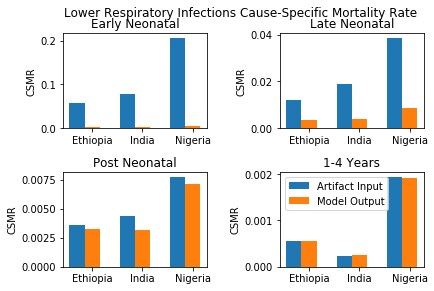

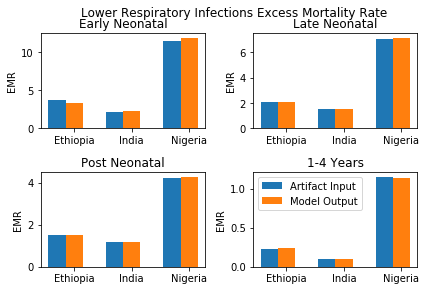

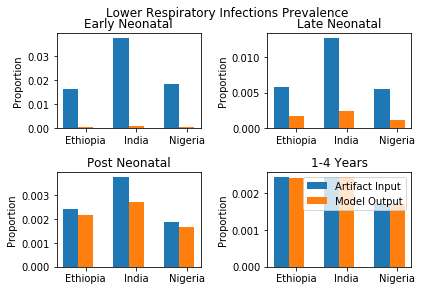

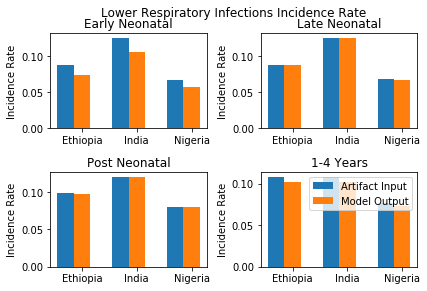

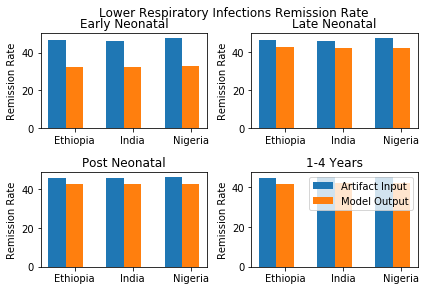

In [11]:
make_and_save_plots('lower_respiratory_infections', lri_model, lri_artifact, 'Lower Respiratory Infections', 'lri')

Researcher questions for LRI model:

1) CSMR:deaths from LRI/total person time
    
    a) in the early and late neonatal age groups our model and artifact CSMRs are not comparable. Our model under-estimates the 
    CSMR.
   
    b) The all-cause mortality rates in the early/late neonatal age groups are comparable, hence we believe this discrepancy is 
    negligible
   
    c) From GBD compare, we see most neonates who die are from from neonatal causes, hence LRI deaths are a small fraction  
     of neonatal deaths, so the ACMR remains comparable. 
 
 2) EMR: deaths from LRI/person time with LRI 
     a) we got this right
     
 3) Prevalence: we initiate the population with the GBD prevalence of the causes, then our model calculates prevalence based on incidence and remission (which is directly pulled from GBD). We use person time with condition/total person time to estimate prevalence in our model after initiation. 
     
     a) we are grossly under-estimating prevalence in the early/late neonatal period. We believe this is because we don't have incidence and remission rates (we pull from GBD) right. 
     
     b) Supporting our belief that GBD's incidence/remission rates are not accurate, we use GBD incidence and remission to approximate prevalence by using the equation of incidence/remission=prevalence. We can see that its incidence/remission not agree with the prevalence by an order of magnitude. 
     
     c) GBD probably calculates prevalence separately from their incidence/remission rates and we trust their prevalence more (?). We'd like more clarification on this from GBD modellers 
     
 4)  Remission: remission rate for LRI is approximately equal for all locations/age groups. Should we trust GBD LRI remission rate data, particularly for the neonatal age groups, as it appears to be driving low LRI prevalence in our model relative to GBD LRI prevalence 

Chris answer: 

1) We allow birth prevalence for LRI and this seems to cause a pretty high prevalence in the earliest age groups.  We observe that there is congenital pneumonia, probably arising from infection during birth.
http://ihmeuw.org/52pk

2) Remission is simply a modeled parameter. We have no data to inform that, we just provide a prior 40-50 (The prior of 40-50 is just that we specify for DisMod that the remission should be between those two values- It is based approximately on the mean duration of LRI according to our data (7.8 days; 365 / 8 =~ 45). I wouldn't focus on that I don't think. Besides your remission is relatively close to the GBD ones.


CONCLUSION- we should try to model birth prevalence subsequent models

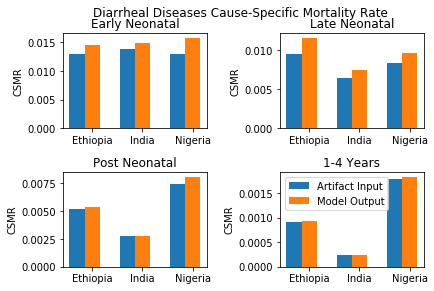

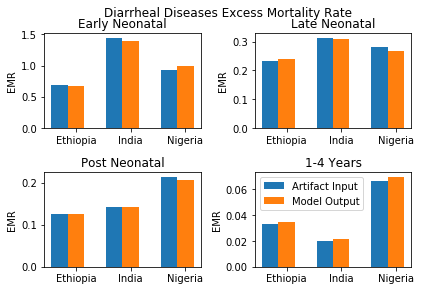

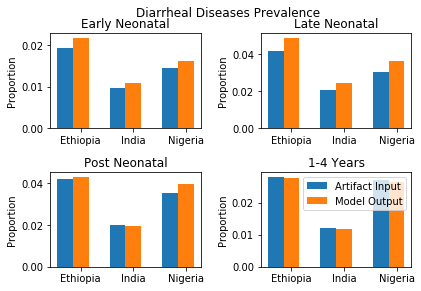

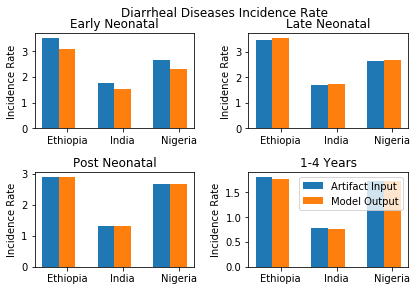

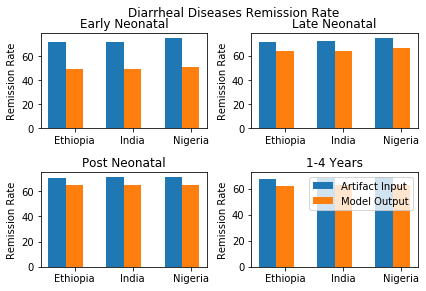

In [12]:
make_and_save_plots('diarrheal_diseases', dd_model, dd_artifact, 'Diarrheal Diseases', 'dd')

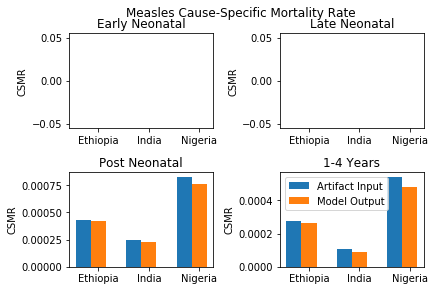

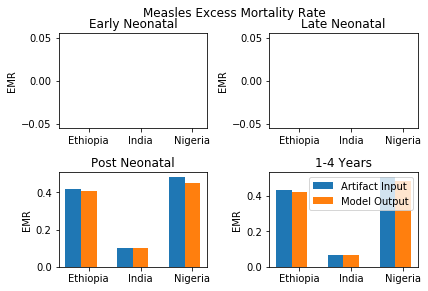

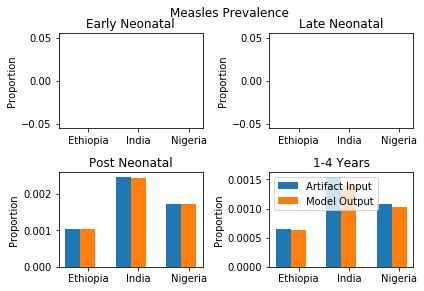

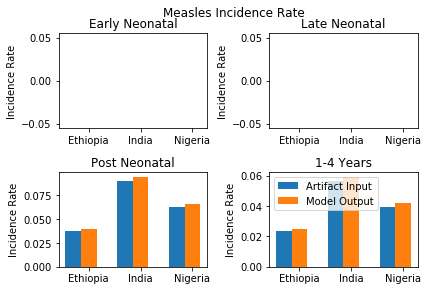

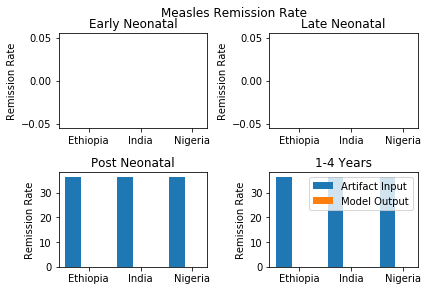

In [13]:
make_and_save_plots('measles', measles_model, measles_artifact, 'Measles', 'measles')

NOTE: there was something wrong with our measles data transformation in count space. We belief measles valiadate despite the remission graphs being off because the cmsrs and prevalence validates